In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%load_ext autoreload
%autoreload 2
from ieee80211phy.transmitter.main import tx_generator
from ieee80211phy.receiver.packet_detector import *

In [2]:
def load_complex64_file(file: str):
    import scipy as sp
    f = sp.fromfile(open(file), dtype=sp.complex64)
    return f

f = load_complex64_file('/home/gaspar/rx_wire')

<IPython.core.display.Javascript object>


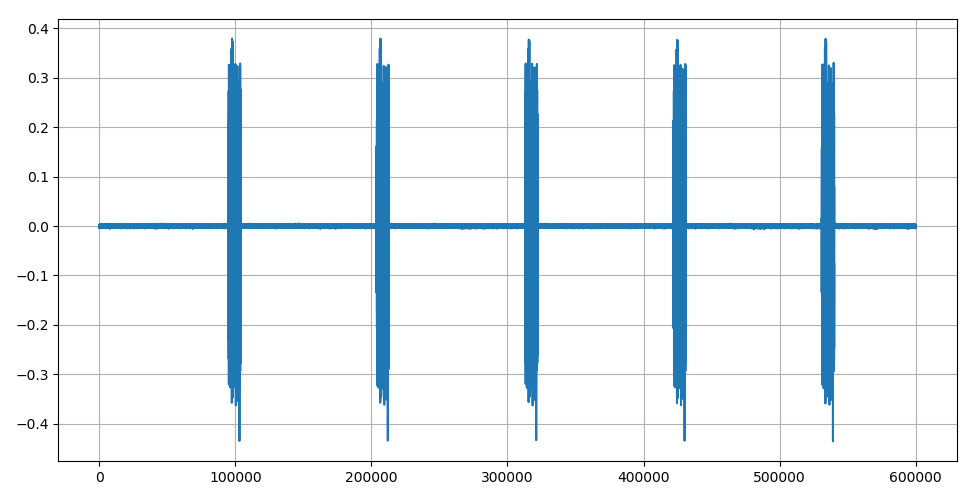

/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [3]:
input = f[1000000:1600000]
plt.figure(figsize=(9.75,5))
plt.plot(input)
plt.tight_layout()
plt.grid()

# Packet detector

/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


94991


<IPython.core.display.Javascript object>


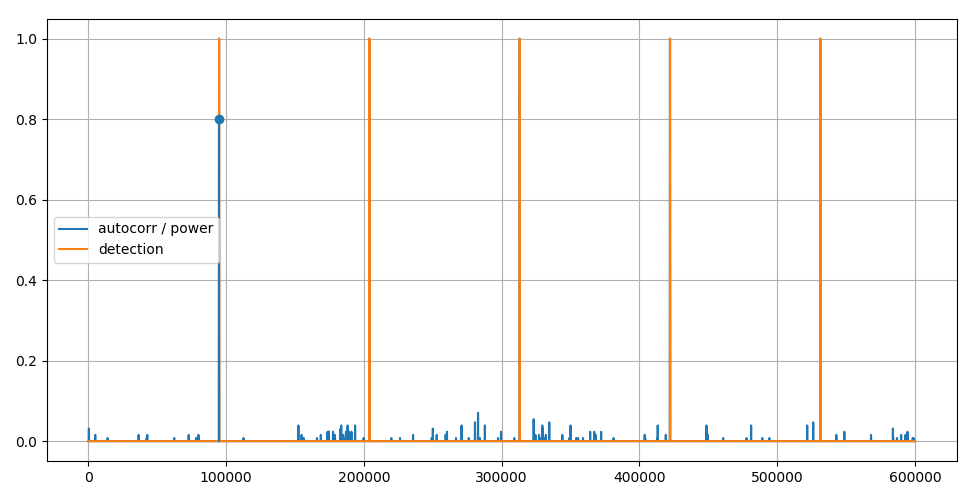

(95058, array([0., 0., 0., ..., 0., 0., 0.]))

In [7]:
packet_detector(input, debug=True)

# Frequency offset compenstaing

In [ ]:
from ieee80211phy.util import *
mult = input[:-16] * np.conjugate(input[16:])
avg = moving_average(mult, 64)
angle = np.angle(avg)

freq_error = angle * (20e6/(2*np.pi*16))
print(f'Coarse freq error is {freq_error[falling_edge_i-50]}')
avg = np.mean(freq_error[64:140])
print(avg)

plt.figure(figsize=(9.75,5))
plt.plot(angle, label='autocorr')
plt.plot(freq_error, label='freq_err')
plt.stem([50], [1.0])
plt.legend()
plt.tight_layout()
plt.grid()

In [ ]:
mult = input[:-16] * np.conjugate(input[16:])
avg = average(mult, 16)
angle = np.angle(avg)

freq_error = angle * (20e6/(2*np.pi*16))
print(f'Coarse freq error is {freq_error[falling_edge_i-50]}')

plt.figure(figsize=(9.75,5))
plt.plot(angle[falling_edge_i-100: falling_edge_i-30], label='autocorr')
plt.plot(freq_error[falling_edge_i-100: falling_edge_i-30], label='freq_err')
plt.stem([50], [1.0])
plt.legend()
plt.tight_layout()
plt.grid()

from ieee80211phy.util import *
fixed = mixer(input, freq_error[falling_edge_i-50], 20e6)

plt.figure(figsize=(9.75,5))
plt.plot(input)
plt.plot(fixed)
plt.legend()
plt.tight_layout()
plt.grid()

In [ ]:
mult = fixed[:-64] * np.conjugate(fixed[64:])
avg = average(mult, 64)
angle = np.angle(avg)

freq_error = angle * (20e6/(2*np.pi*64))
print(f'Coarse freq error is {freq_error[falling_edge_i+125]}')

plt.figure(figsize=(9.75,5))
plt.plot(angle[falling_edge_i+100: falling_edge_i+200], label='autocorr')
plt.plot(freq_error[falling_edge_i+100: falling_edge_i+200], label='freq_err')
plt.stem([25], [1.0])
plt.legend()
plt.tight_layout()
plt.grid()

# from ieee80211phy.util import *
# fixed = mixer(input, freq_error[falling_edge_i-50], 20e6)

# plt.figure(figsize=(9.75,5))
# plt.plot(input)
# plt.plot(fixed)
# plt.legend()
# plt.tight_layout()
# plt.grid()

In [ ]:
from ieee80211phy.transmitter.preamble import long_train_symbol
import scipy
long_symbol = long_train_symbol()
corr = scipy.signal.correlate(input, long_symbol)
corr_sign = scipy.signal.correlate(input, np.sign(long_symbol))
corr_sign /= corr_sign.max() / corr.max()

# skip over the first 'halfpeak' - whcih is from guard interval!
long_training_peak = np.argmax(corr[falling_edge_i+54: falling_edge_i+54+64]) + falling_edge_i+54 + 1
print(long_training_peak)

plt.figure(figsize=(9.75,5))
plt.plot(corr, label='corr')
plt.plot(corr_sign, label='sign')
plt.scatter([long_training_peak], [1.0], label='first_peak_pos')
plt.xlim([long_training_peak-64, long_training_peak+128])
# plt.xlim([0, 500])
plt.legend()
plt.tight_layout()
plt.grid()


plt.figure(figsize=(9.75,5))
plt.plot(long_symbol, label='ideal_long')
plt.plot(input[long_training_peak-64:long_training_peak], label='detected_long')
plt.legend()
plt.tight_layout()
plt.grid()


In [ ]:
sample_advance = 4
rx = input[long_training_peak-64-sample_advance:]

# Equalizer

In [ ]:
from ieee80211phy.transmitter.preamble import *
ideal_long = long_train_symbol()
first_long_train = rx[:64]
second_long_train = rx[64:64+64]
avg_long_train = (first_long_train + second_long_train) / 2
freq = np.fft.fft(avg_long_train)*(1/64)

print(np.fft.fft(ideal_long))
# ideal_freq  [0, 0, 0, 0, 0, 0, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1,
#                   1,
#                   0,
#                   1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 0, 0, 0, 0,
#                   0]

channel_estimate = freq / (np.fft.fft(ideal_long)*(1/64))
equalizer_coefs = 1/channel_estimate



plt.figure(figsize=(9.75,5))
plt.ylim([-6, 2])
plt.plot()
plt.plot(np.fft.fftshift(20*np.log10(np.abs(equalizer_coefs))))
# plt.plot(equalizer_coefs)
# plt.plot(first_long_train)
# plt.plot(second_long_train)
# plt.plot(avg_long_train)
plt.tight_layout()
plt.grid()

plt.figure(figsize=(9.75,5))
plt.plot(np.fft.fftshift(np.fft.ifft(equalizer_coefs, 128)))
plt.tight_layout()
plt.grid()

# RX

In [ ]:
np.random.seed(0)
data = ''.join('1' if x else '0' for x in np.random.randint(2, size=20906))
tx, maps, ofdm_syms = tx_generator(data, data_rate=36)
from ieee80211phy.transmitter.ofdm_modulation import *

no_head = rx[128:128 + (109*80)]

plt.figure(figsize=(9.75,5))
plt.plot(no_head)
plt.tight_layout()
plt.grid()

# symbols = np.reshape(no_head, (-1, 80))
# freq = [np.fft.fft(x[16:]) for x in symbols]

# equalized = freq
# # print(equalizer_coefs)
# # equalized = [x * equalizer_coefs for x in freq]
# symbols = np.array([demap_from_carriers(x) for x in equalized])

# symbols_flat = symbols.flatten()


In [ ]:
from ieee80211phy.util import *
plot_rx(symbols, ofdm_syms)

In [ ]:
plt.figure(figsize=(9.75,5))
plt.plot(symbols)
plt.plot(maps)
plt.tight_layout()
plt.grid()

In [ ]:
from ieee80211phy.transmitter.subcarrier_modulation_mapping import *
# symbols = np.array([QAM16_LUT_NORM[i>>2] + QAM16_LUT_NORM[i&3] * 1j for i in range(16)])
symbols = np.array([QAM64_LUT_NORM[i>>3] + QAM64_LUT_NORM[i&7] * 1j for i in range(64)])
print(symbols)
pwr = [power(x) for x in symbols]
print(pwr, np.mean(pwr))

plt.figure(figsize=(9.75,5))
plt.scatter(symbols.real, symbols.imag)
plt.tight_layout()
tick_base = 1 / np.sqrt(10)
plt.xticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
plt.yticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
plt.grid()